In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

100%|██████████| 492M/492M [00:24<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


 Dataset path: /kaggle/input/price-volume-data-for-all-us-stocks-etfs

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8364 non-null   datetime64[ns]
 1   Open     8364 non-null   float64       
 2   High     8364 non-null   float64       
 3   Low      8364 non-null   float64       
 4   Close    8364 non-null   float64       
 5   Volume   8364 non-null   int64         
 6   OpenInt  8364 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 457.5 KB
None
                             Date         Open         High          Low  \
count                        8364  8364.000000  8364.000000  8364.000000   
mean   2001-04-04 07:55:00.430416    22.284350    22.495867    22.054244   
min           1984-09-07 00:00:00     0.233050     0.235640     0.230510   
25%           1992-12-1

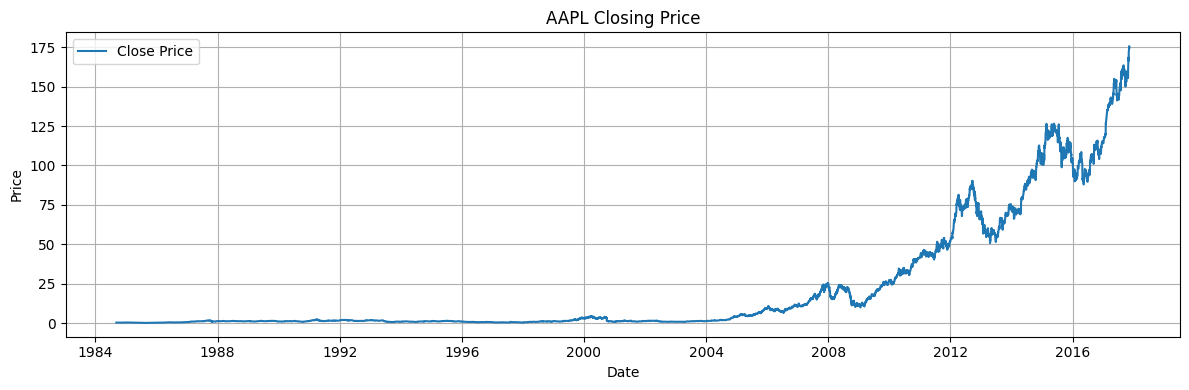


 Random Forest:
MSE: 2946.7183153684086
R² Score: -2.0057178688185626

 XGBoost:
MSE: 2916.6149126958494
R² Score: -1.9750117321467107
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - loss: 0.0045
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 4.6069e-04
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 4.2864e-04
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 3.9492e-04
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 3.8976e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step

 LSTM:
MSE: 35.92595594451242
R² Score: 0.4042969961093761
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0043
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4793e-04
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6976e-04
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0716e-04
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2550e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

 CNN:
MSE: 30.0607691982

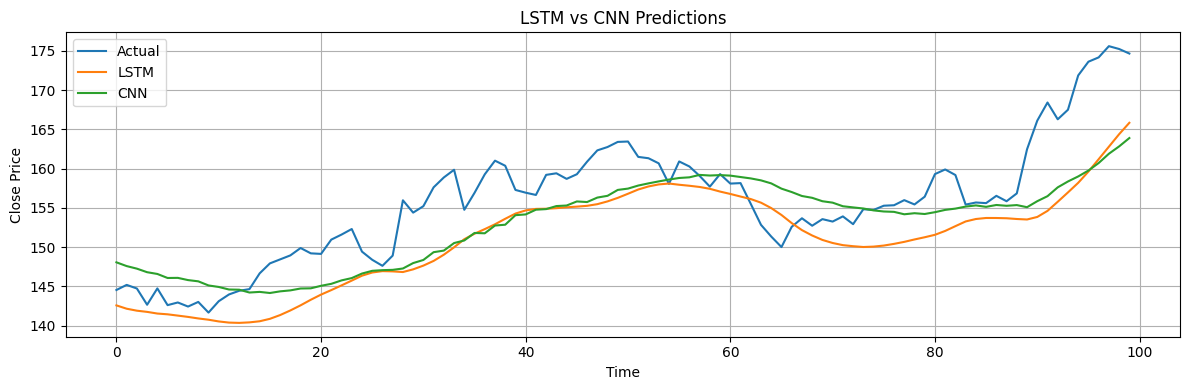

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# 1. Download dataset
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")
print(" Dataset path:", path)

# 2. Load AAPL file
file_path = os.path.join(path, "Stocks", "aapl.us.txt")
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# 3. EDA
print("\n Dataset Info:")
print(df.info())
print(df.describe())
print("Missing:\n", df.isnull().sum())

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4. ML Dataset Preparation
df_ml = df[['Open', 'High', 'Low', 'Volume', 'Close']].dropna()
X = df_ml.drop('Close', axis=1)
y = df_ml['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R² Score:", r2_score(y_test, y_pred_rf))

# 6. XGBoost
xg_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
xg_model.fit(X_train, y_train)
y_pred_xgb = xg_model.predict(X_test)

print("\n XGBoost:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R² Score:", r2_score(y_test, y_pred_xgb))

# 7. DL Data Preparation (Close Price Only)
close_scaled = MinMaxScaler().fit_transform(df[['Close']].dropna())
seq_len = 60
X_seq, y_seq = [], []
for i in range(seq_len, len(close_scaled)):
    X_seq.append(close_scaled[i - seq_len:i])
    y_seq.append(close_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)
X_train_dl, X_test_dl = X_seq[:-100], X_seq[-100:]
y_train_dl, y_test_dl = y_seq[:-100], y_seq[-100:]

# 8. LSTM Model
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_dl.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train_dl, y_train_dl, epochs=5, batch_size=32, verbose=1)

y_pred_lstm = lstm.predict(X_test_dl)
y_pred_lstm_inv = MinMaxScaler().fit(df[['Close']].dropna()).inverse_transform(y_pred_lstm)
y_test_lstm_inv = MinMaxScaler().fit(df[['Close']].dropna()).inverse_transform(y_test_dl.reshape(-1, 1))

print("\n LSTM:")
print("MSE:", mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))
print("R² Score:", r2_score(y_test_lstm_inv, y_pred_lstm_inv))

# 9. CNN Model
cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn.compile(optimizer='adam', loss='mse')
cnn.fit(X_train_dl, y_train_dl, epochs=5, batch_size=32, verbose=1)

y_pred_cnn = cnn.predict(X_test_dl)
y_pred_cnn_inv = MinMaxScaler().fit(df[['Close']].dropna()).inverse_transform(y_pred_cnn)

print("\n CNN:")
print("MSE:", mean_squared_error(y_test_lstm_inv, y_pred_cnn_inv))
print("R² Score:", r2_score(y_test_lstm_inv, y_pred_cnn_inv))

# 10. Visualize LSTM vs CNN
plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='LSTM')
plt.plot(y_pred_cnn_inv, label='CNN')
plt.title("LSTM vs CNN Predictions")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
